In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_curve, auc

from rdkit import Chem
from rdkit.Chem import Descriptors

from rdkit.Chem import Crippen

In [23]:
DF = pd.read_csv('PTP1B_LIGREF.csv')
print(len(DF))
DF = DF[DF['IC50'] > 0].copy()
DF['pIC50'] = 9 - np.log10(DF['IC50'])
print(len(DF))

3051
3051


In [38]:
# Clasificación binaria
#busqueda
DF['activo'] = DF['pIC50'].apply(lambda x: 1 if x >= 4 else 0)

In [39]:

# Función para contar átomos pesados
def contar_nha(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return mol.GetNumHeavyAtoms()
    else:
        return None

# Crear la columna con número de átomos pesados
DF['NHA'] = DF['SMILES'].apply(contar_nha)

# Calcular la eficiencia del ligando usando pIC50
DF['LE_MOE'] = - (DF['S_MOE'] / DF['NHA'])

DF['LE_Ledock'] = - (DF['S_Ledock'] / DF['NHA'])

DF['LE_VINA'] = - (DF['S_VINA'] / DF['NHA'])

In [40]:
def calculate_logP(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Crippen.MolLogP(mol)
    return None  # Manejo de errores si el SMILES no es válido

DF['logP'] = DF['SMILES'].apply(calculate_logP)

In [41]:
DF['LELP_MOE'] = DF['logP'] / DF['LE_MOE']
DF['LELP_Ledock'] = DF['logP'] / DF['LE_Ledock']
DF['LELP_VINA'] = DF['logP'] / DF['LE_VINA']

In [42]:
DF.to_csv('PTP1B_LIGREF_3ROC_4corte.csv')

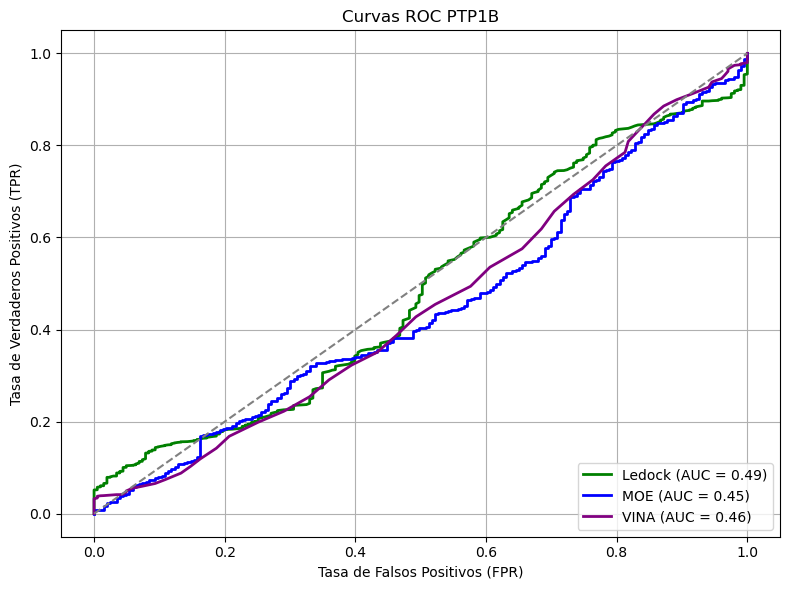

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Diccionario con los métodos y sus columnas
metodos = {
    'Ledock': 'S_Ledock',
    'MOE': 'S_MOE',
    'VINA': 'S_VINA'
}

y_true = DF['activo']

plt.figure(figsize=(8, 6))

# Colores para cada curva
colores = ['green', 'blue', 'purple']

# Generar la curva ROC por cada método
for (nombre, columna), color in zip(metodos.items(), colores):
    if columna in DF.columns:
        y_scores = -DF[columna]  # invertimos el score si es docking
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{nombre} (AUC = {roc_auc:.2f})')

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Etiquetas y formato
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC PTP1B')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

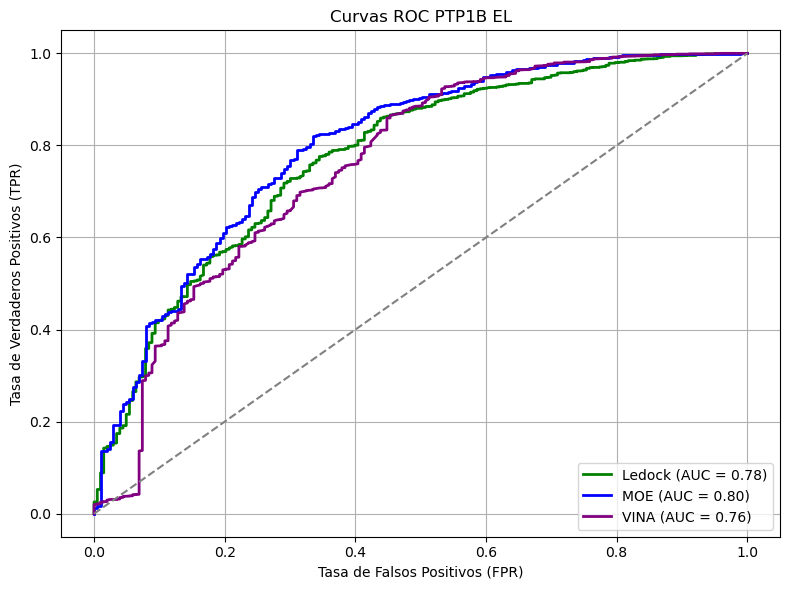

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Diccionario con los métodos y sus columnas
metodos = {
    'Ledock': 'LE_Ledock',
    'MOE': 'LE_MOE',
    'VINA': 'LE_VINA'
}

y_true = DF['activo']

plt.figure(figsize=(8, 6))

# Colores para cada curva
colores = ['green', 'blue', 'purple']

# Generar la curva ROC por cada método
for (nombre, columna), color in zip(metodos.items(), colores):
    if columna in DF.columns:
        y_scores = -DF[columna]  # invertimos el score si es docking
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{nombre} (AUC = {roc_auc:.2f})')

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Etiquetas y formato
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC PTP1B EL')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()